Device: cuda
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inpl

C:\Users\hoang\AppData\Local\Temp\ipykernel_8728\2361752020.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("D:/saved_models/ba


Normal Test Accuracy: 0.8849

=== Normal Test Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.8269    0.8515    0.8390       101
                     Pepper__bell___healthy     0.9346    0.9597    0.9470       149
                      Potato___Early_blight     0.8333    0.9500    0.8879       100
                       Potato___Late_blight     0.8776    0.8600    0.8687       100
                           Potato___healthy     0.8421    1.0000    0.9143        16
                      Tomato_Bacterial_spot     0.8596    0.9159    0.8869       214
                        Tomato_Early_blight     0.7315    0.7900    0.7596       100
                         Tomato_Late_blight     0.9367    0.7708    0.8457       192
                           Tomato_Leaf_Mold     0.8913    0.8542    0.8723        96
                  Tomato_Septoria_leaf_spot     0.7919    0.7697    0.7806  

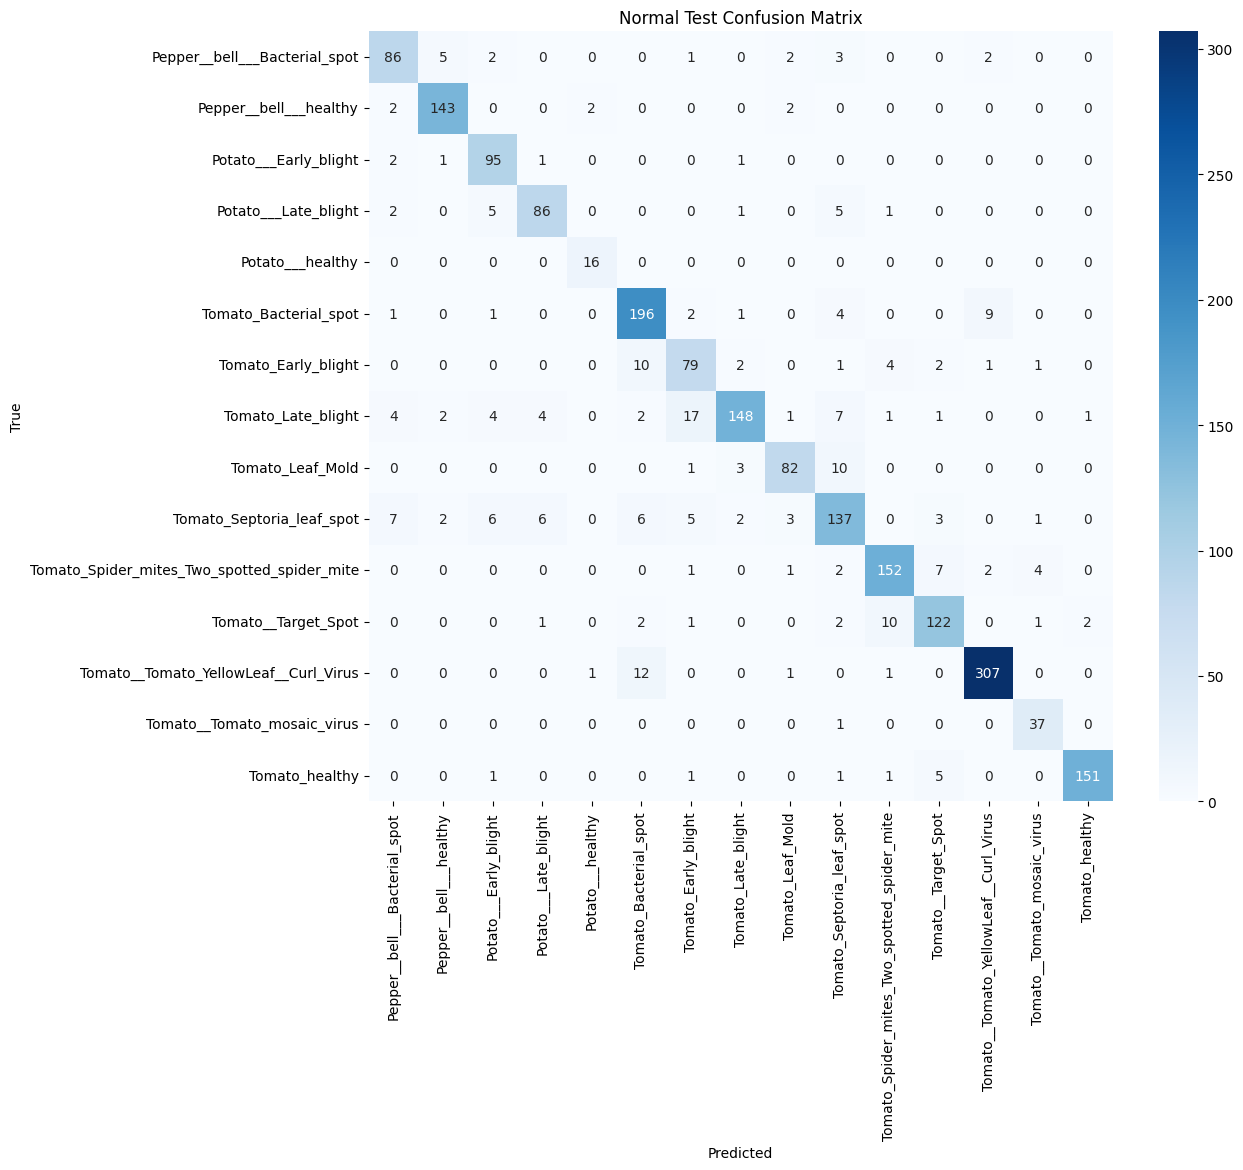


Hard Test Accuracy: 0.3907

=== Hard Test Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.2201    0.3465    0.2692       101
                     Pepper__bell___healthy     0.4821    0.6309    0.5465       149
                      Potato___Early_blight     0.4286    0.5400    0.4779       100
                       Potato___Late_blight     0.4737    0.1800    0.2609       100
                           Potato___healthy     0.6250    0.3125    0.4167        16
                      Tomato_Bacterial_spot     0.5755    0.3738    0.4533       214
                        Tomato_Early_blight     0.1413    0.5300    0.2232       100
                         Tomato_Late_blight     0.2539    0.6823    0.3701       192
                           Tomato_Leaf_Mold     0.5833    0.3646    0.4487        96
                  Tomato_Septoria_leaf_spot     0.5472    0.1629    0.2511      

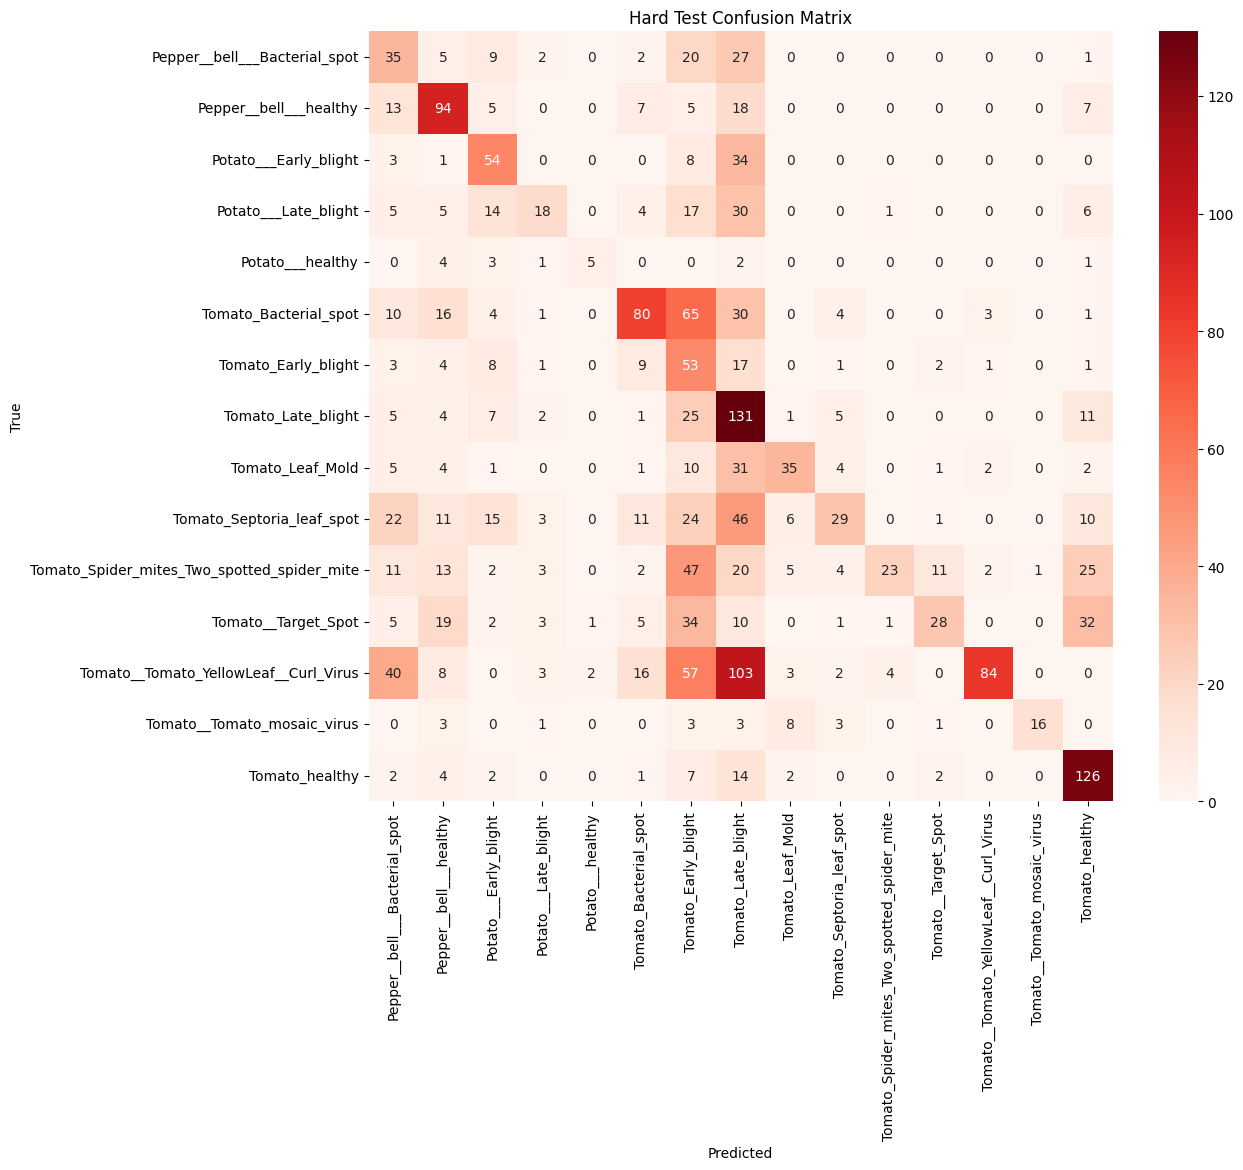

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 15      
DATA_ROOT = r"D:\dataset_split"
LEARNING_RATE = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/train", transform = train_transform)
val_dataset   = datasets.ImageFolder(root = f"{DATA_ROOT}/val", transform = val_transform)

targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler = sampler)
val_loader   = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*56*56, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss, running_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = running_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
# Save model

torch.save(model.state_dict(), "D:/saved_models/baseline_cnn.pt")


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Normal Test
test_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/test", transform = val_transform)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

loaded_model = SimpleCNN(num_classes).to(device)
loaded_model.load_state_dict(torch.load("D:/saved_models/baseline_cnn.pt"))
loaded_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = loaded_model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
normal_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nNormal Test Accuracy: {normal_acc:.4f}")

# Classification report
print("\n=== Normal Test Classification Report ===")
print(classification_report(all_labels, all_preds, target_names = test_dataset.classes, digits = 4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = test_dataset.classes,
            yticklabels = test_dataset.classes)
plt.title("Normal Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Hard Test
hard_test_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
])
hard_test_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/test", transform = hard_test_transform)
hard_test_loader  = DataLoader(hard_test_dataset, batch_size = BATCH_SIZE, shuffle = False)

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in hard_test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = loaded_model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
hard_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nHard Test Accuracy: {hard_acc:.4f}")

# Classification report
print("\n=== Hard Test Classification Report ===")
print(classification_report(all_labels, all_preds, target_names = test_dataset.classes, digits = 4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Reds",
            xticklabels = test_dataset.classes,
            yticklabels = test_dataset.classes)
plt.title("Hard Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
